In [1]:
from visualizer import draw_dot
from head2grad import Value

In [2]:
v1 = Value(1, label='v1')
v2 = Value(2, label='v2')
v3 = v1 + v2; v3.label = 'v3'
v4 = Value(-5, label='v4')
v5 = v4 * v3; v5.label = 'v5'

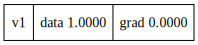

In [3]:
draw_dot(v1)

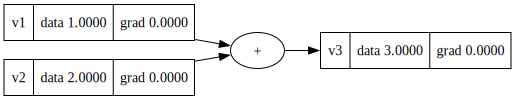

In [4]:
draw_dot(v3)

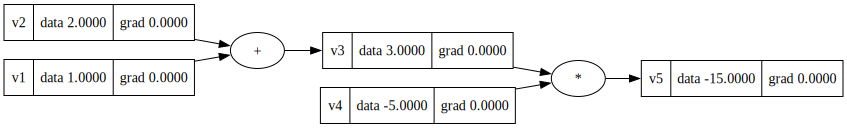

In [5]:
draw_dot(v5)

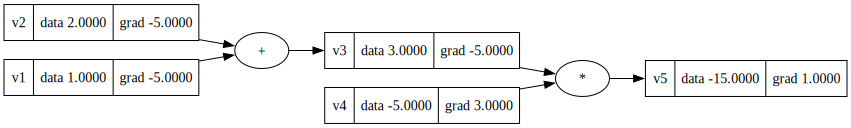

In [6]:
v5.backward()
draw_dot(v5)

### Tanh and topological

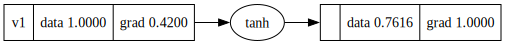

In [7]:
v1 = Value(1, label='v1')
v2 = v1.tanh()
v2.backward()
draw_dot(v2)

In [8]:
from head2grad import build_topological

build_topological(v5, [])

[Value(data=-15), Value(data=3), Value(data=2), Value(data=1), Value(data=-5)]

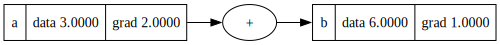

In [9]:
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)